<!--## ATM Queue-->

## Simple Queue Model

Let's explore the expressiveness of `kalasim`s process description using a *traditional queuing* example, the [M/M/1](https://en.wikipedia.org/wiki/M/M/1_queue). This [Kendall's notation](https://en.wikipedia.org/wiki/Kendall%27s_notation) describes a single server - here a ATM - with exponentially distributed arrivals, exponential service time and an infinte queue.
<!--see Ucar2019, 4.1 for more details-->

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Mm1_queue.svg/440px-Mm1_queue.svg.png)

The basic parameters of the system are

* λ - people arrival rate at the ATM
* µ - money withdrawal rate

If  λ/µ > 1, the queue is referred to as *unstable* since there are more arrivals than the ATM can handle. The queue will grow indefinitely.


In [1]:
@file:Repository("*mavenLocal")
@file:DependsOn("com.github.holgerbrandl:kalasim:0.6.97")

//@file:DependsOn("com.github.holgerbrandl:kalasim:0.6.92")
@file:DependsOn("com.github.holgerbrandl:kravis:0.8.1")
@file:DependsOn("org.jetbrains.kotlinx:kotlinx-coroutines-core:1.5.2")

In [2]:
import kotlinx.coroutines.*
import krangl.*
import krangl.cumSum
import kravis.geomTile
import kravis.plot
import org.kalasim.*
import org.kalasim.misc.*
import org.kalasim.plot.kravis.display
import org.koin.core.Koin

Let's start simply. First, we work out the basic model without much code reusability in mind.


The ATM example is inspired from the `simmer` paper [Ucar et al. 2019](https://www.jstatsoft.org/article/view/v090i02).


In [4]:
 val sim = createSimulation {
    val lambda = 1.5
    val mu = 1.0
    val rho = lambda / mu

    println(
        "rho is ${rho}. With rho>1 the system would be unstable, " +
                "because there are more arrivals then the atm can serve."
    )

    val atm = Resource("atm", 1)

    class Customer() : Component() {
        val ed = exponential(mu)

        override fun process() = sequence {

            request(atm)

            hold(ed.sample())
            release(atm)
        }
    }

    ComponentGenerator(iat = exponential(lambda)) { Customer() }

    run(2000)

    atm.occupancyTimeline.display()
    atm.requesters.queueLengthMonitor.display()
    atm.requesters.lengthOfStayMonitor.display()

    println("\nqueue statistics: ${atm.requesters.lengthOfStayMonitor.statistics()}")
}


rho is 1.5. With rho>1 the system would be unstable, because there are more arrivals then the atm can serve.

queue statistics: {
  "entries": 1312,
  "median": 3.268,
  "mean": 2.061,
  "ninety_pct_quantile": 6.321,
  "standard_deviation": 3.268,
  "ninetyfive_pct_quantile": 9.091
}


## Simple WhatIf

To explore the impact of `lambda` and `mu` on these statistics, we rework the example to become a bit more generic.

In [5]:
class AtmCustomer(
    val mu: Double,
    val atm: Resource,
    koin: Koin = DependencyContext.get()
) : Component(koin = koin) {
    val ed = exponential(mu)

    override fun process() = sequence {
        request(atm)

        hold(ed.sample())
        release(atm)
    }
}

class AtmQueue(val lambda: Double, val mu: Double) : Environment() {
    val atm = dependency { Resource("atm", 1) }

    init {
        ComponentGenerator(iat = exponential(lambda)) {
            AtmCustomer(mu, atm, koin = getKoin())
        }
    }
}

Then, we evaluate a parameter grid.

In [6]:
   // build parameter grid
val lambdas = (1..20).map { 0.25 }.cumSum()
val mus = (1..20).map { 0.25 }.cumSum()

// run 100x times
val atms = cartesianProduct(lambdas, mus).map { (lambda, mu) ->
    AtmQueue(lambda, mu).apply { run(100) }
}

We now extract the ATM parameters along with he mean queue length of each ATM instance into a data-frame.

In [7]:
atms.map {
    it to it.get<Resource>().statistics.requesters.lengthStats.mean!!.roundAny(2)
}.toList()
    .asDataFrame()
    .unfold<AtmQueue>("first", listOf("mu", "lambda"), keep=false)
    .rename("second" to "mean_queue_length")


mean_queue_length,lambda,mu
8.25,0.25,0.25
113.83,0.25,0.5
149.73,0.25,0.75
172.69,0.25,1.0
178.59,0.25,1.25
206.61,0.25,1.5
188.26,0.25,1.75
205.89,0.25,2.0
209.68,0.25,2.25
210.42,0.25,2.5


## Parallel WhatIf

Very often, simulation models are complex, so running different simulations in parellel allows to minimize overall execution time

First, we build a number of sims (as `Sequence`) and work them out in parallel using kotlin coroutines.

In [9]:
val atms = cartesianProduct(lambdas, mus).asIterable().map { (lambda, mu) ->
    // instantiate sequentially to simplify dependency injection
    AtmQueue(lambda, mu)
}.toList()

// define parallelization helper to run in parallel
// https://stackoverflow.com/questions/34697828/parallel-operations|-on-kotlin-collections
fun <A, B> Iterable<A>.pmap(f: suspend (A) -> B): List<B> = runBlocking {
    map { async(newFixedThreadPoolContext(4, "")) { f(it) } }.map { it.await() }
}

// simulate in parallel
atms.pmap {
    it.run(100)
}.forEach{} // supppress the output

Something really cool has just happened. We have run as many simulations in parallel as there are cores on this computer.

Next, we can summarize our findings by visualizing the results in usin a heatmap.

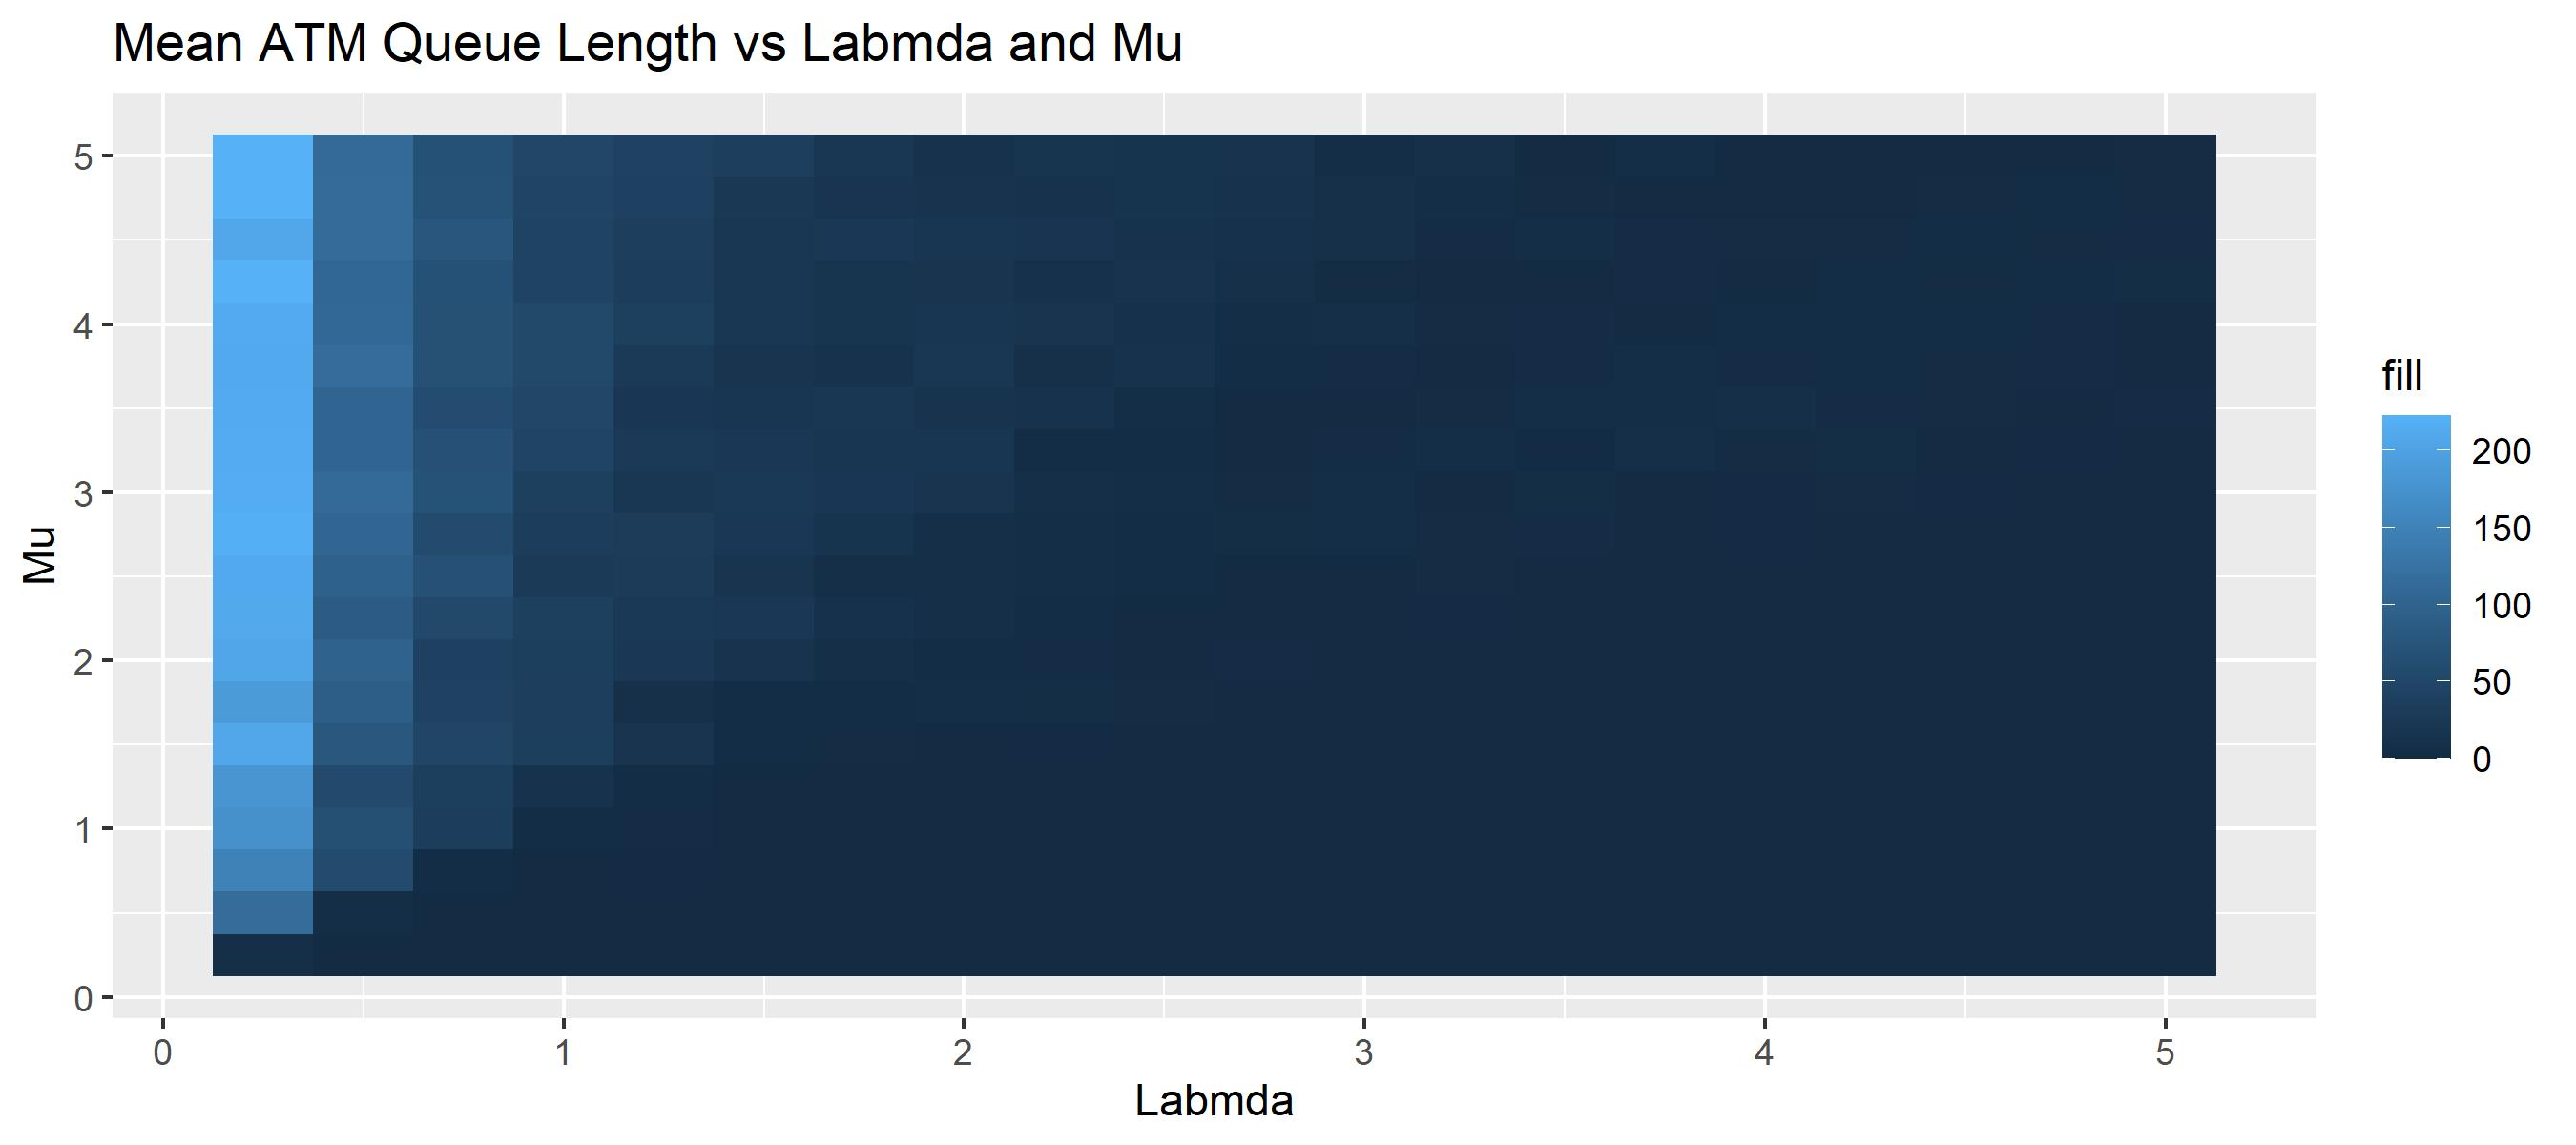

In [10]:
// extract stats and visualize
val meanQLength = atms.map { it to it.get<Resource>().statistics.requesters.lengthStats.mean!! }

meanQLength.plot(x = { first.lambda }, y = { first.mu }, fill = { second })
    .geomTile()
    .title("Mean ATM Queue Length vs Labmda and Mu")
    .xLabel("Labmda").yLabel("Mu")

## Conclusion

In this example we have explored a simple simulation model. In in fact we have not built just a single model, but instead we have modelled a range of ATMs with differeing settings to better understand the dynamics of the process at hand.

For complete sources, also see the jupyter [notebook](https://nbviewer.org/github/holgerbrandl/kalasim/blob/master/docs/userguide/docs/examples/atm_queue.ipynb) or plain [kotlin sources](https://github.com/holgerbrandl/kalasim/blob/master/src/test/kotlin/org/kalasim/examples/atm/Atm.kt). Feel welcome to [get in touch](../index.md#support) for support, suggestions, and questions.